# Import libraries

In [10]:
import os
from re import search
from dfply import *

# Load settings

In [31]:
if search("ricard", os.uname()[1]):
    exec(open('/Users/ricard/gastrulation10x/settings.py').read())
    exec(open('/Users/ricard/gastrulation10x/utils.py').read())
elif search("ebi", os.uname()[1]):
    exec(open('/homes/ricard/gastrulation10x/settings.py').read())
    exec(open('/homes/ricard/gastrulation10x/utils.py').read())
else:
    exit("Computer not recognised")

## Define I/O

In [32]:
io["outdir"] = io["basedir"] + "/..."

## Define options 

scanpy options

In [7]:
# %%capture
# sc.settings.verbosity = 3
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(8, 7), facecolor='white')

In [8]:
opts["stages"] = [
	"E6.5",
	"E6.75",
	"E7.0",
	"E7.25",
	"E7.5",
	"E7.75",
	"E8.0",
	"E8.25",
	"E8.5",
	"mixed_gastrulation"
]

opts["celltypes"] = [
   # "Epiblast",
   # "Primitive_Streak",
   # "Caudal_epiblast",
   # "PGC",
   # "Anterior_Primitive_Streak",
   # "Notochord",
   # "Def._endoderm",
   # "Gut",
   # "Nascent_mesoderm",
   "Mixed_mesoderm",
   # "Intermediate_mesoderm",
   # "Caudal_Mesoderm",
   # "Paraxial_mesoderm",
   # "Somitic_mesoderm",
   # "Pharyngeal_mesoderm",
   # "Cardiomyocytes",
   # "Allantois",
   # "ExE_mesoderm",
   # "Mesenchyme",
   "Haematoendothelial_progenitors",
   "Endothelium",
   "Blood_progenitors_1",
   "Blood_progenitors_2",
   "Erythroid1",
   "Erythroid2",
   "Erythroid3"
   # "NMP",
   # "Rostral_neurectoderm",
   # "Caudal_neurectoderm",
   # "Neural_crest",
   # "Forebrain_Midbrain_Hindbrain",
   # "Spinal_cord",
   # "Surface_ectoderm",
   # "Visceral_endoderm",
   # "ExE_endoderm",
   # "ExE_ectoderm",
   # "Parietal_endoderm"
]

## Load cell metadata

In [14]:
metadata = (pd.read_table(io["metadata"]) >>
    mask(X["stripped"]==False, X["doublet"]==False) >>
    mask(X["stage"].isin(opts["stages"]), X["celltype"].isin(opts["celltypes"]))
)
metadata.shape

(15875, 12)

In [15]:
metadata.head()

,cell,barcode,sample,stage,sequencing.batch,doublet,stripped,celltype,umapX,umapY,nFeature_RNA,nCount_RNA
11,cell_100006,GACTGTGAGGACAG,29,E8.5,3,False,False,Erythroid3,8.538226,7.548652,2819,18907
20,cell_100015,GACTTTACTGGATC,29,E8.5,3,False,False,Erythroid3,9.761636,5.911193,3115,21040
26,cell_100020,GAGAAATGCCACAA,29,E8.5,3,False,False,Erythroid3,9.623819,6.548942,3002,20182
38,cell_100032,GAGATAGATACTCT,29,E8.5,3,False,False,Haematoendothelial_progenitors,-1.219938,11.407623,2334,7092
45,cell_100040,GAGATGCTCTGTAG,29,E8.5,3,False,False,Erythroid2,8.000846,9.198536,3795,26487


# Load anndata object

In [33]:
adata = load_adata(
    adata_file = io["anndata"], 
    metadata_file = io["metadata"],
    cells = metadata.cell.values, 
    normalise = True, 
    filter_lowly_expressed_genes = True
)
adata

filtered out 13501 genes that are detected in less than 10 counts


Trying to set attribute `.var` of view, copying.


normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 15875 × 15951
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'doublet', 'stripped', 'celltype', 'umapX', 'umapY', 'nFeature_RNA', 'nCount_RNA'
    var: 'n_counts'
    uns: 'celltype_colors', 'clusterMergedHierarchy_colors', 'clusterMergedHierarchy_sizes', 'clusterSubUnique_colors', 'clusterSubUnique_sizes', 'diffmap_evals', 'neighbors', 'paga', 'stage_colors', 'log1p'
    obsm: 'X_pca', 'X_umap', 'X_tsne', 'X_diffmap'
    obsp: 'distances', 'connectivities'

In [36]:
adata.obs["celltype"].value_counts()

Erythroid1                        2929
Haematoendothelial_progenitors    2733
Erythroid3                        2697
Blood_progenitors_2               2587
Mixed_mesoderm                    1994
Erythroid2                        1106
Endothelium                       1084
Blood_progenitors_1                745
Name: celltype, dtype: int64

... storing 'barcode' as categorical
... storing 'stage' as categorical
... storing 'celltype' as categorical


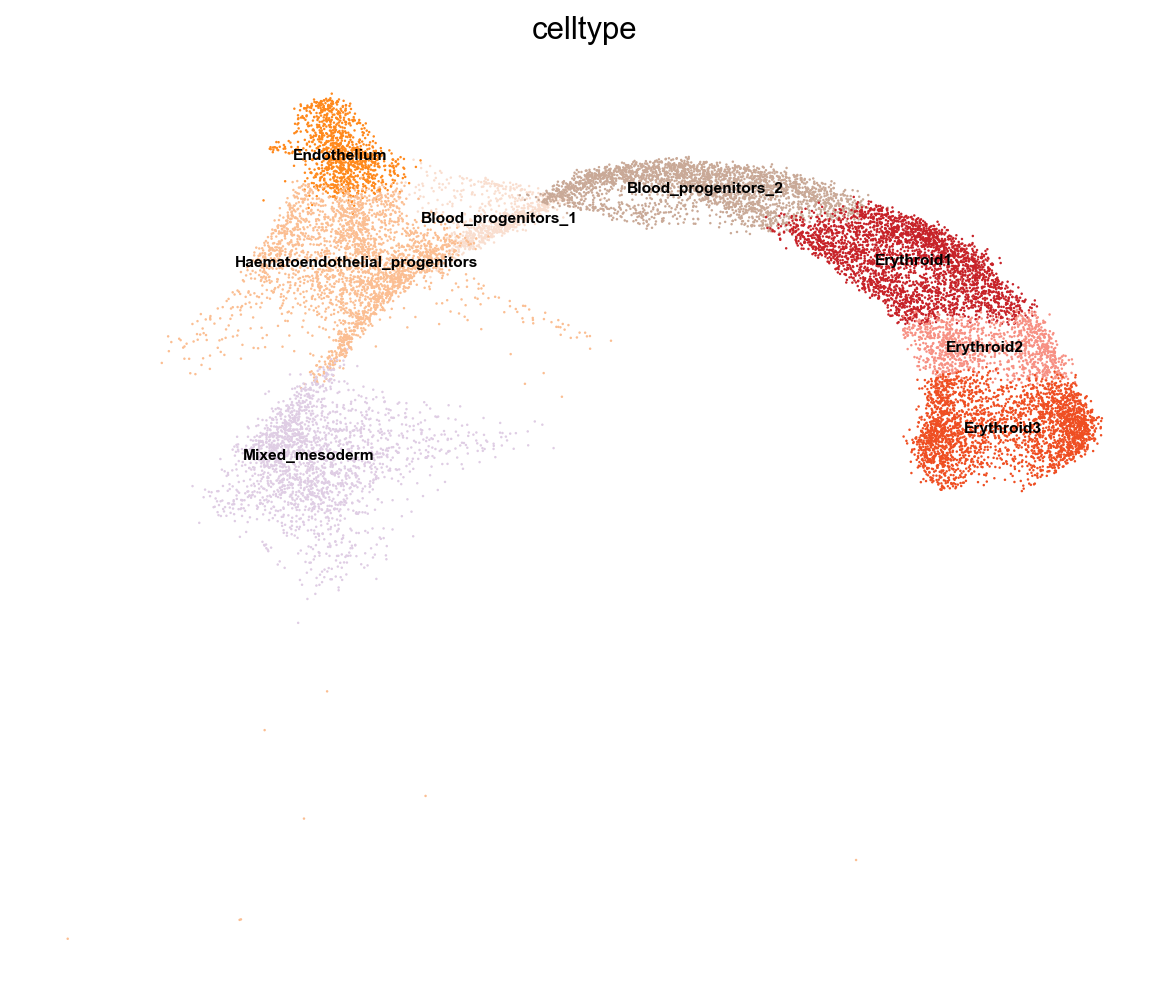

In [37]:
sc.pl.scatter(adata, color='celltype', basis="umap", size=5, legend_loc='on data', legend_fontsize=7)

## Feature selection

In [38]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [40]:
adata.var["highly_variable"].sum()

1000

## Dimensionality reduction

### PCA

In [41]:
sc.tl.pca(adata, n_comps=15)

computing PCA
    on highly variable genes
    with n_comps=15
    finished (0:00:01)


## Compute neighbors

In [46]:
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)


### UMAP

In [47]:
sc.tl.umap(adata, min_dist=0.3, spread=1.0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


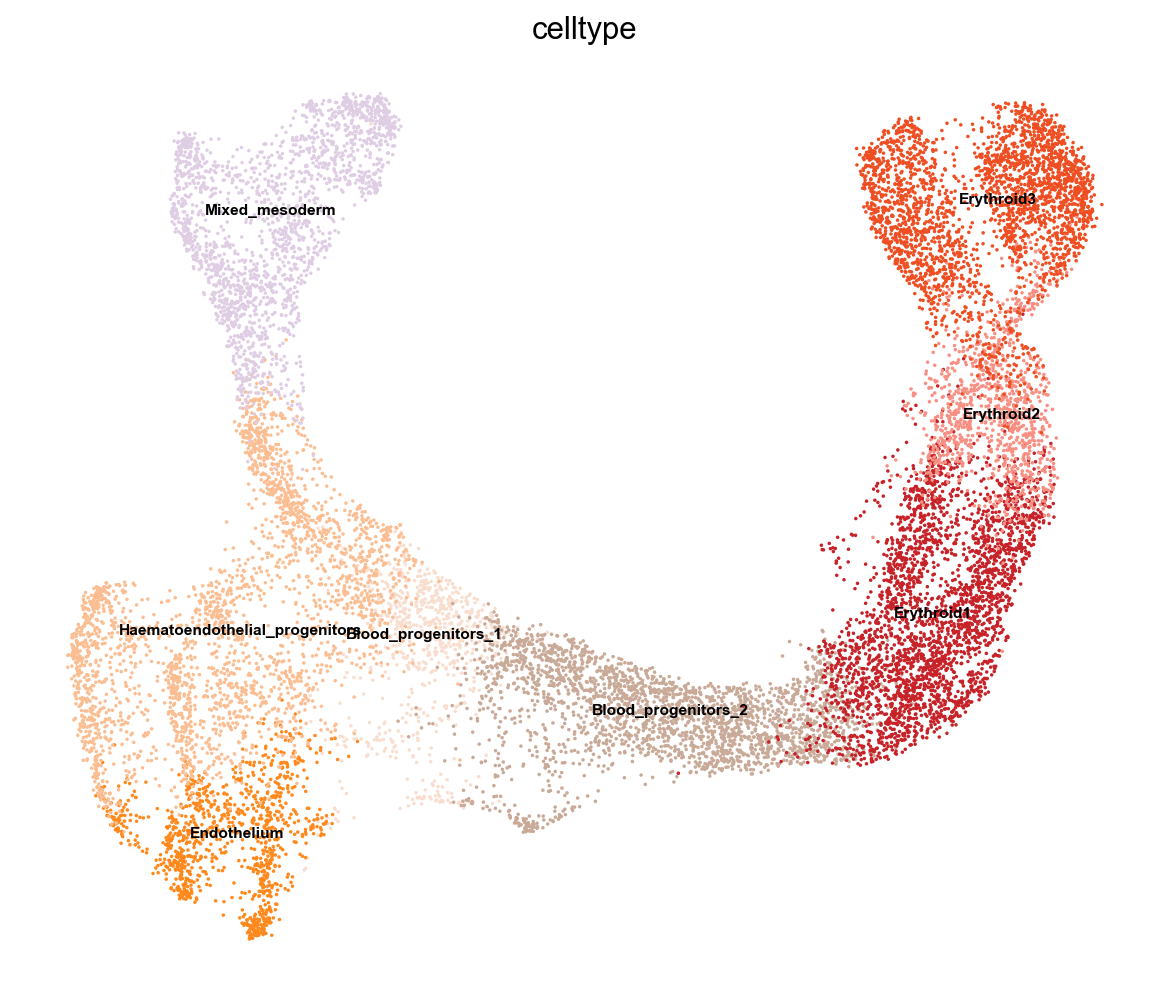

In [48]:
sc.pl.scatter(adata, color='celltype', basis="umap", size=10, legend_loc='on data', legend_fontsize=7)

In [34]:
adata.obsm.keys()

KeysView(AxisArrays with keys: X_pca, X_umap, X_tsne, X_diffmap)

### Force-directed layout

In [49]:
sc.tl.draw_graph(adata, layout='fa', init_pos=None)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:03:12)


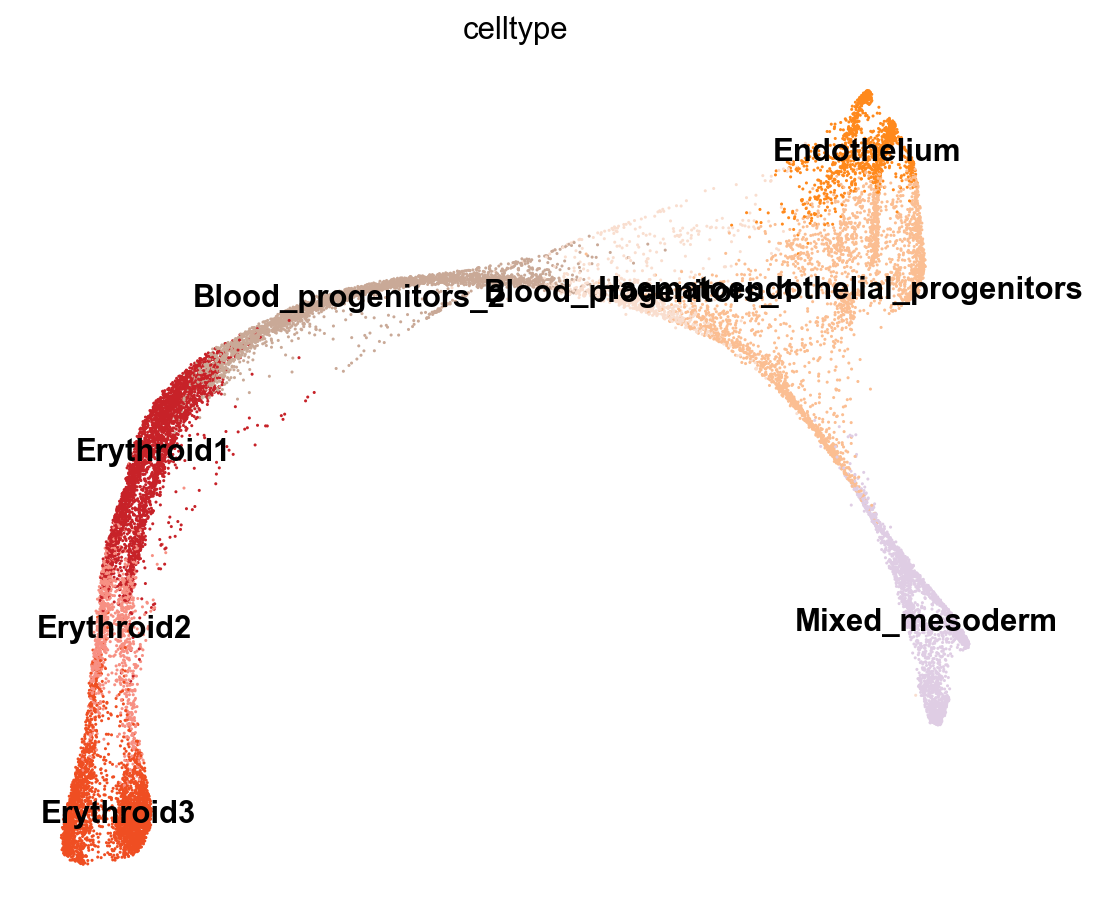

In [50]:
sc.pl.draw_graph(adata, color='celltype', legend_loc='on data')

## Graph abstraction


In [51]:
sc.tl.paga(adata, groups='celltype')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)


--> added 'pos', the PAGA positions (adata.uns['paga'])


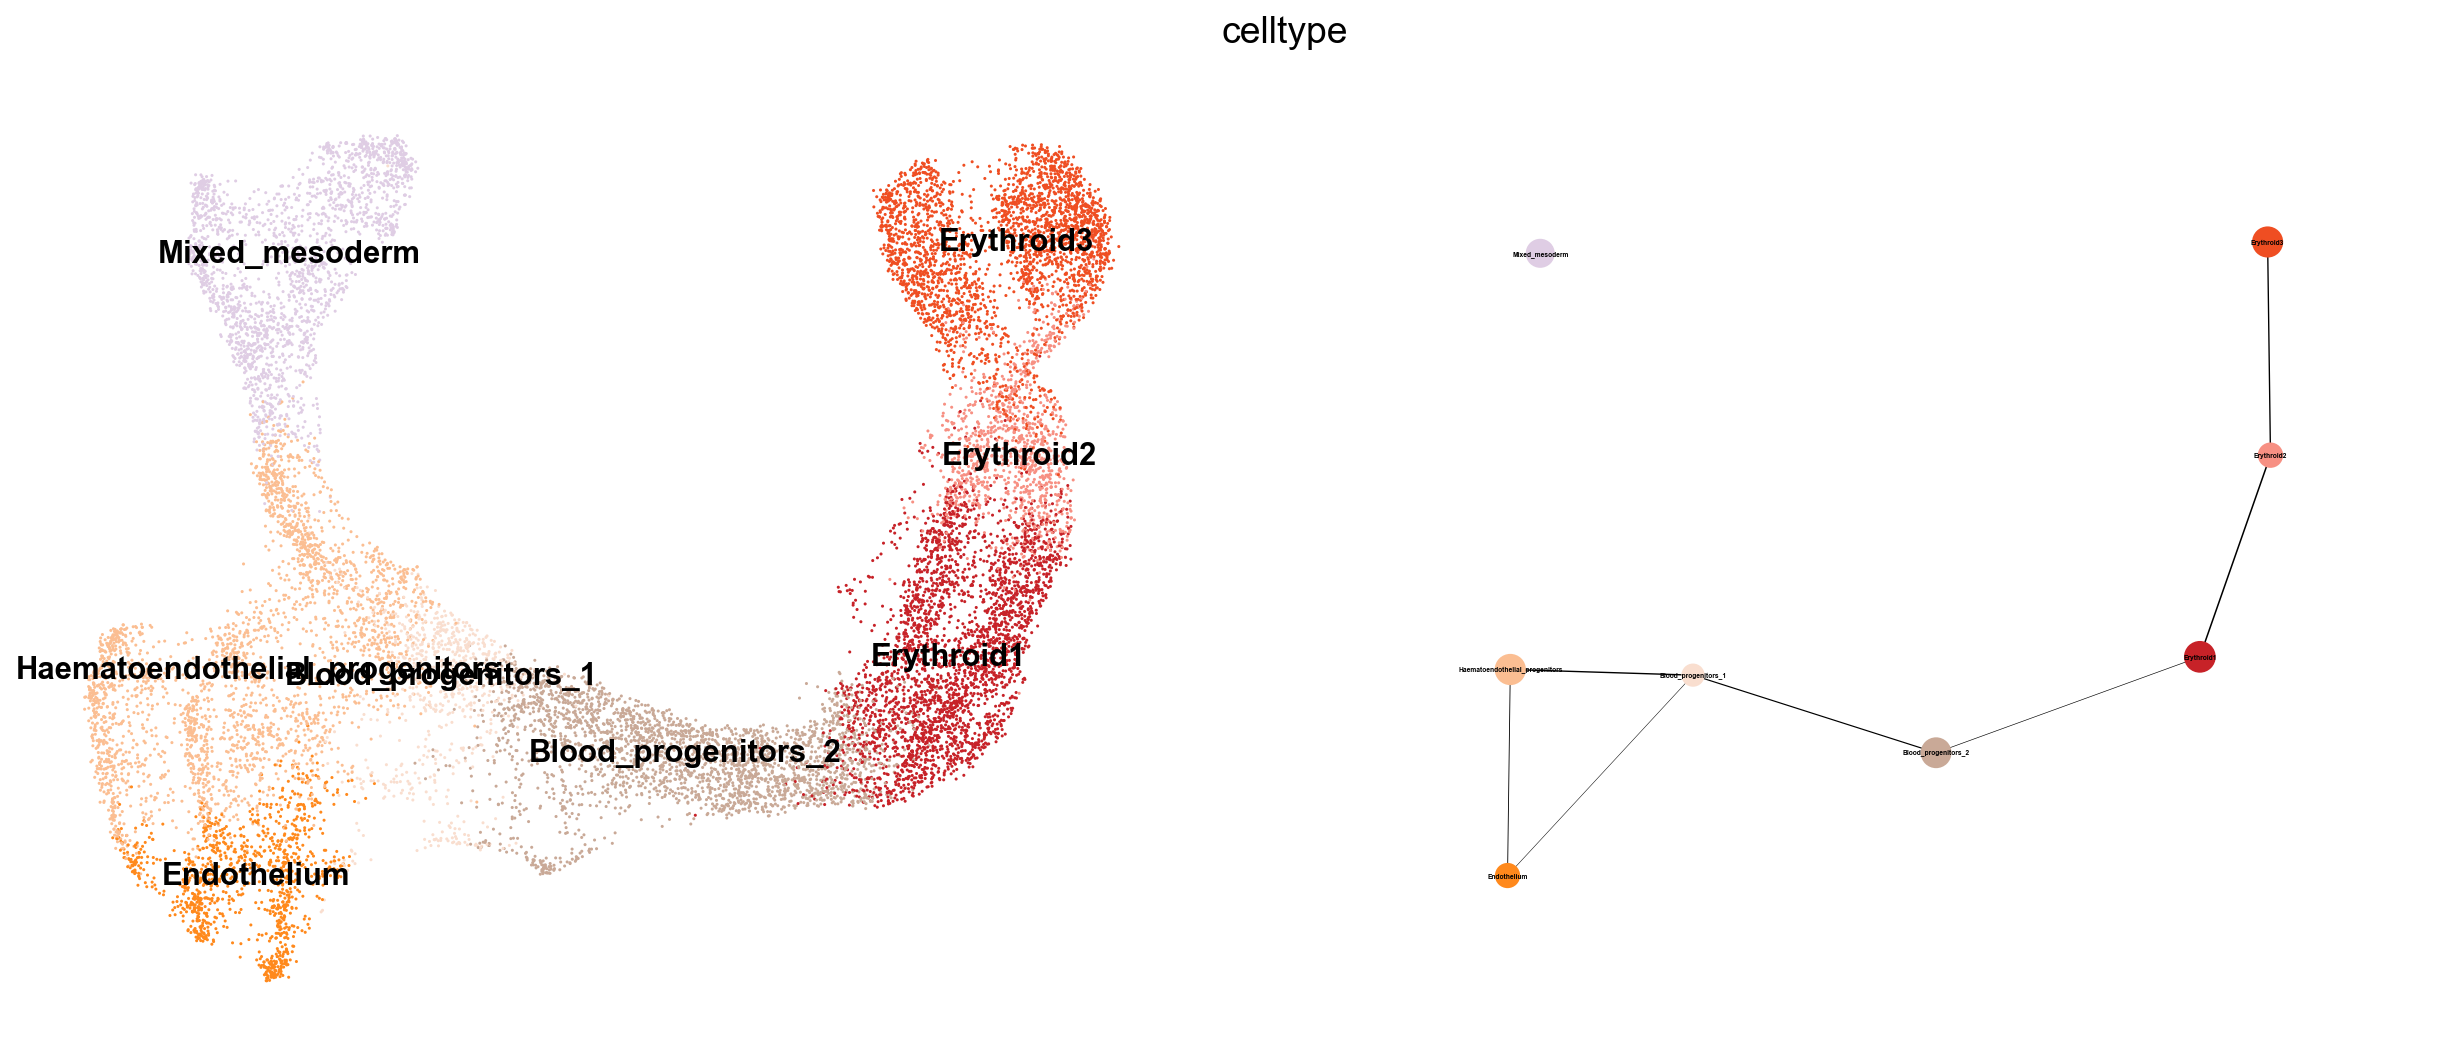

In [52]:
sc.pl.paga_compare(adata, basis='umap',legend_loc='on data',
                   fontsize=3, threshold=0.23, color='celltype', edge_width_scale=0.1)

--> added 'pos', the PAGA positions (adata.uns['paga'])


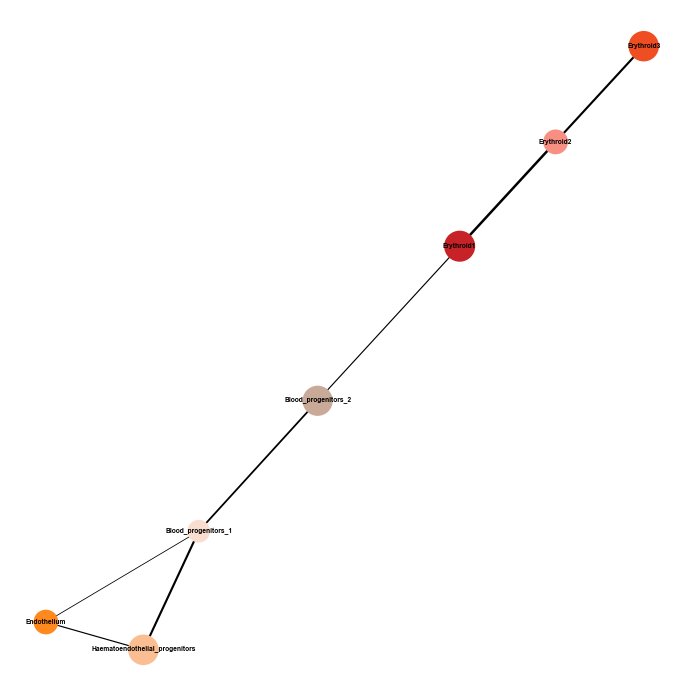

In [38]:
sc.pl.paga(adata, threshold=0.3, fontsize=3, edge_width_scale=0.15, node_size_power=0.5, color='celltype')

recomputing the graph using PAGA initialisation

In [53]:
sc.tl.draw_graph(adata, layout='fa', init_pos="paga")

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:03:13)


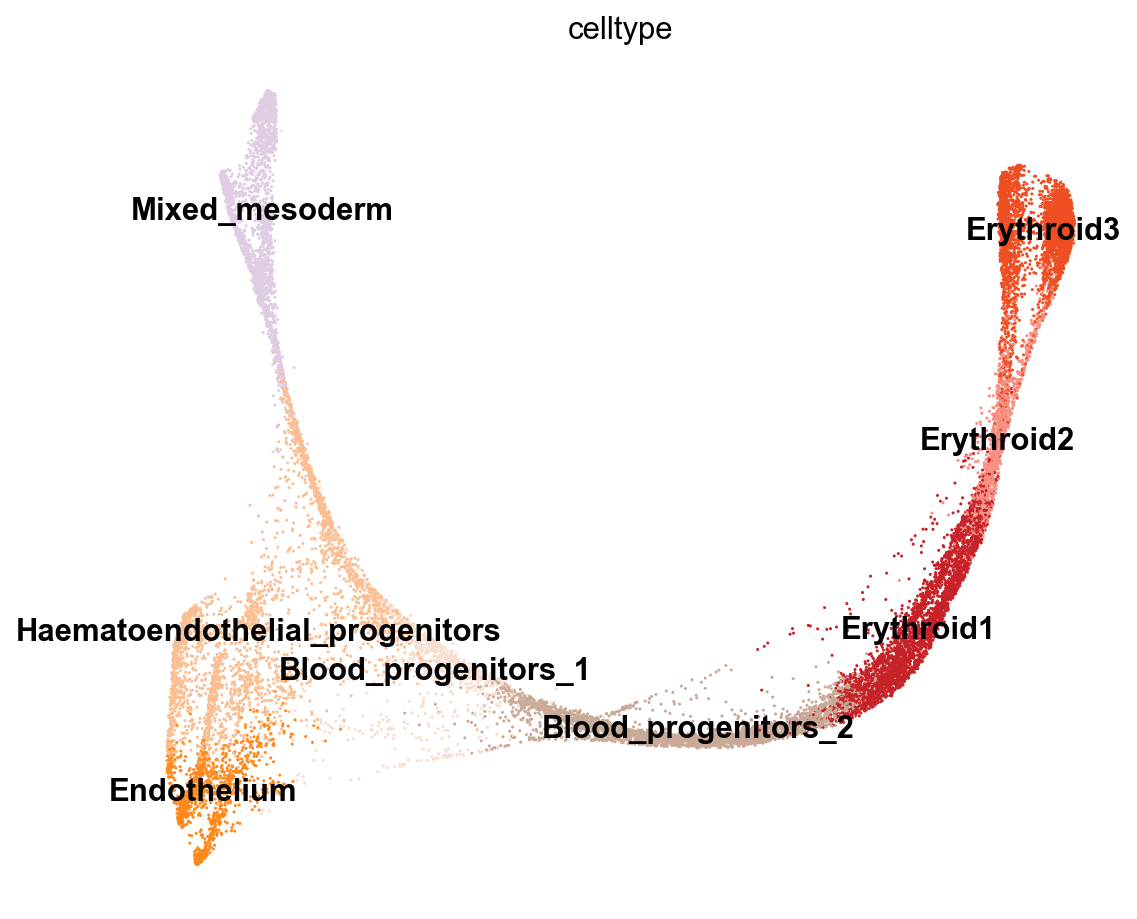

In [54]:
sc.pl.draw_graph(adata, color='celltype', legend_loc='on data')